In [31]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # at init, grad is 0 because we don't know the gradient yet during forward pass
        self.grad = 0.0
        # set of previous nodes - '_children' because viewed during backward pass (parents if viewed from forward pass)
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None 
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data + other.data, (self, other), '+', f'{self.label}+{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        out = Value(self.data * other.data, (self, other), '*', f'{self.label}*{other.label}')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float constants powers for now"
        
        out = Value(self.data ** other, (self,), '**', f'{self.label}**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward

        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-', f'{self.label}-{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += -1 * out.grad

        out._backward = _backward

        return out

    def __rsub__(self, other):
        return other + (-self)
    
    def tanh(self):
        # Karpathy's a chad so he implements tanh himself
        out = Value(math.tanh(self.data), (self,), 'tanh', f'tanh({self.label})')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)
        build_topo(self)

        # Set the output node's grad to 1.0
        self.grad = 1.0

        # Go through nodes in reverse topological order
        for node in reversed(topo):
            node._backward()

In [32]:
x = Value(-3.0, label='x')

z = x**2

z.grad = 1.0
z.backward()
print(z)


Value(data=9.0, label=x**2, grad=1.0)


In [33]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Manual Backprop

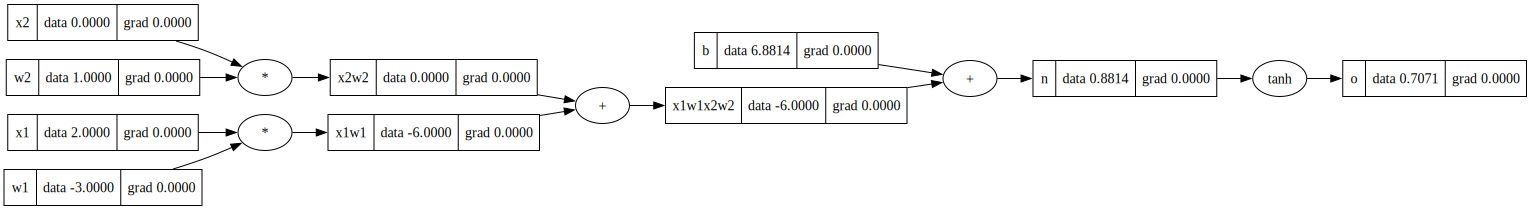

In [34]:
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [35]:
o.grad = 1.0
o._backward()

n._backward()
print(n)

x1w1x2w2._backward()
print(x1w1x2w2)

x1w1._backward()
print(x1w1)

x2w2._backward()
print(x2w2)

x1._backward()
print(x1)

x2._backward()

Value(data=0.8813735870195432, label=n, grad=0.4999999999999999)
Value(data=-6.0, label=x1w1x2w2, grad=0.4999999999999999)
Value(data=-6.0, label=x1w1, grad=0.4999999999999999)
Value(data=0.0, label=x2w2, grad=0.4999999999999999)
Value(data=2.0, label=x1, grad=-1.4999999999999996)


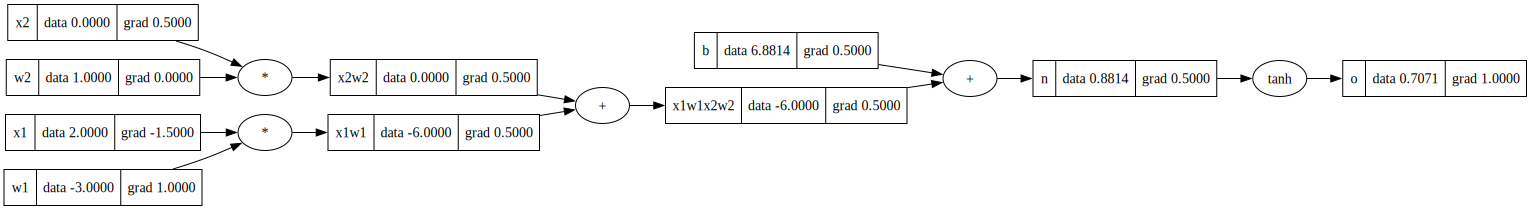

In [36]:
draw_dot(o)

### Autograd

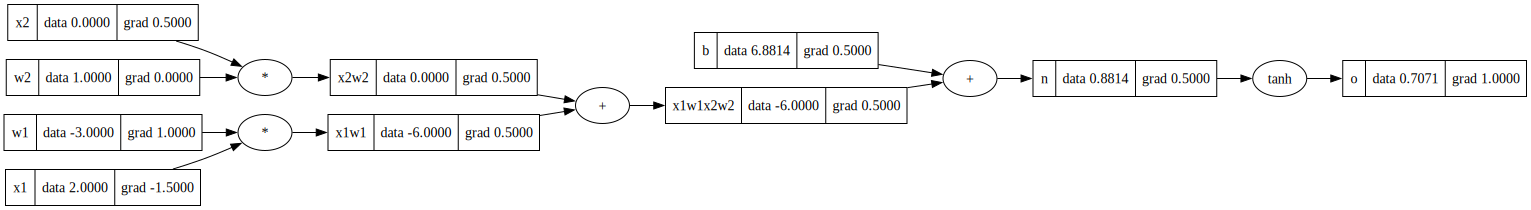

In [37]:
x1 = Value(2.0, label='x1')
x2 = Value(0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

In [41]:
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.grad = 1.0
b.backward()

print(a.data, a.grad, b.data, b.grad)

2.0 2.0 4.0 1.0


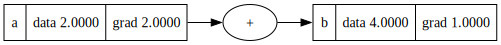

In [42]:
draw_dot(b)

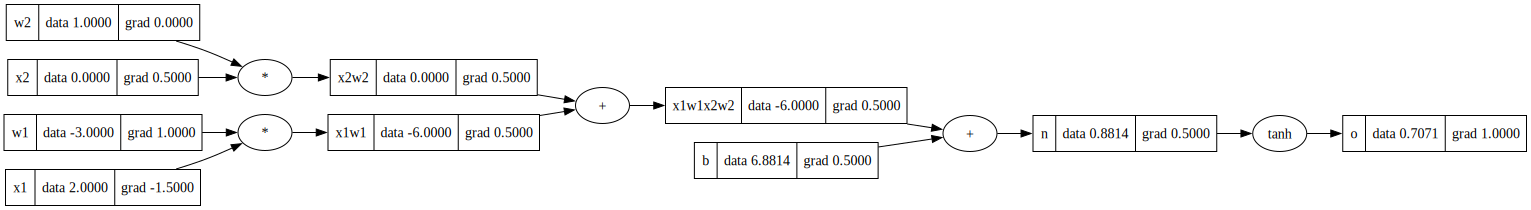

In [43]:
x1, x2 = Value(2.0, label='x1'), Value(0, label='x2')

w1, w2 = Value(-3.0, label='w1'), Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

## Simple NN Libary

In [136]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for i in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((xi*wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out

In [139]:
class Layer:
    def __init__(self, nin, nout):
        """
        nin: number of input neurons
        nout: number of output neurons
        """
        self.neurons = [Neuron(nin) for n in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

**Q. Does the #inputs have to be the same for all the neurons in the same layer?**  
-> Not technically. However, this ensures that all the neurons in a layer are influenced by the outputs from the previous layer.

In [135]:
x = [2.0, 3.0]

In [132]:
ns = Layer(2, 3)
ns(x)

[Value(data=0.5521933800618852, label=tanh(+*+*), grad=0.0),
 Value(data=-0.999668623480067, label=tanh(+*+*), grad=0.0),
 Value(data=0.9512046148649475, label=tanh(+*+*), grad=0.0)]